<a href="https://colab.research.google.com/github/youchulJ/YOLOv8_Custom_Gwanganri_Detection/blob/main/KMI_project_part2(data_processing_part).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##New model input video upload



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [ ]:
SOURCE_VIDEO_PATH = f"/content/drive/MyDrive/yolov8/다대포산책로/DJI_0910.MP4"

##New model weight setting - step 1


In [ ]:
#!unzip /content/drive/MyDrive/weights2.zip

Archive:  /content/drive/MyDrive/weights2.zip
replace runs/detect/train2/weights/best.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: runs/detect/train2/weights/best.pt  
replace runs/detect/train2/weights/last.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: runs/detect/train2/weights/last.pt  


In [ ]:
# settings
#MODEL = "runs/detect/train2/weights/best.pt "

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Aug 14 05:26:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **23.01.2023** with version **YOLOv8.0.17**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.77 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.6/78.2 GB disk)


## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Supervision

In [ ]:
!pip install supervision==0.1.0

from IPython import display
display.clear_output()

import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
# settings
!unzip /content/drive/MyDrive/yolov8/다대포산책로/weights.zip

Archive:  /content/drive/MyDrive/yolov8/다대포산책로/weights.zip
   creating: runs/detect/train/weights/
  inflating: runs/detect/train/weights/best.pt  
  inflating: runs/detect/train/weights/last.pt  


In [ ]:
MODEL = "runs/detect/train/weights/best.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
model.model.names
# class_ids of interest - car, motorcycle, bus and truck
#CLASS_ID = [0, 1, 2]

{0: 'Bicycle',
 1: 'Dogs',
 2: 'Person-lying-sitting',
 3: 'Person-swimming',
 4: 'Person-walking',
 5: 'Scooter'}


0: 384x640 1 Person-lying-sitting, 46.0ms
Speed: 15.6ms preprocess, 46.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


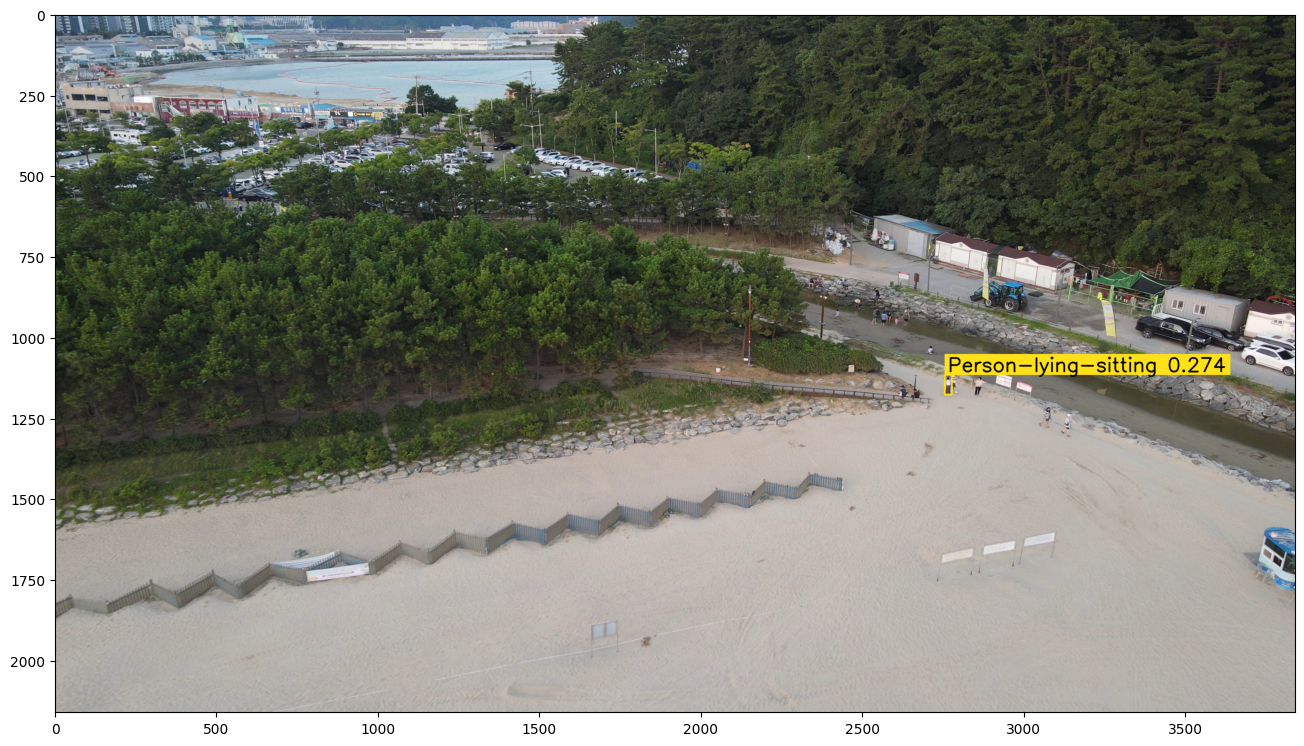

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.3f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

##Predict the video- .avi

In [ ]:
#!yolo task=detect mode=predict model=yolov8s.pt conf=0.25 source={SOURCE_VIDEO_PATH}

100% 21.5M/21.5M [00:00<00:00, 264MB/s]
Ultralytics YOLOv8.0.175 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

video 1/1 (1/1804) /content/drive/MyDrive/DJI_0861.MP4: 384x640 2 persons, 1 car, 1 airplane, 2 backpacks, 1 frisbee, 62.3ms
video 1/1 (2/1804) /content/drive/MyDrive/DJI_0861.MP4: 384x640 2 persons, 1 car, 1 airplane, 1 backpack, 1 frisbee, 11.3ms
video 1/1 (3/1804) /content/drive/MyDrive/DJI_0861.MP4: 384x640 1 person, 1 car, 1 airplane, 1 truck, 1 frisbee, 11.3ms
video 1/1 (4/1804) /content/drive/MyDrive/DJI_0861.MP4: 384x640 1 person, 1 car, 15.9ms
video 1/1 (5/1804) /content/drive/MyDrive/DJI_0861.MP4: 384x640 1 person, 1 car, 1 airplane, 1 truck, 11.3ms
video 1/1 (6/1804) /content/drive/MyDrive/DJI_0861.MP4: 384x640 1 person, 1 car, 1 airplane, 11.3ms
video 1/1 (7/1804) /content/drive/MyDrive/DJI_0861.MP4: 384x640 1 person, 2 cars, 1 airplane, 11.3ms
video 1/1 (8/1804) /c

## Predict and annotate whole video

In [ ]:
TARGET_VIDEO_PATH = f"/content/drive/MyDrive/yolov8/다대포산책로/DADEAPO_0806_점심.MP4"

In [ ]:
# settings
#TARGET_VIDEO_PATH = f"{HOME}/drone-survey-result1.mp4"

In [ ]:
from supervision.video.dataclasses import VideoInfo

VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=29, total_frames=5202)

In [ ]:
from supervision.video.source import get_video_frames_generator
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.draw.color import ColorPalette
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# Initialize an empty list for labels
#labels = []
# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)

        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )

        # tracking detections
       # tracks = byte_tracker.update(
       #     output_results=detections2boxes(detections=detections),
       #     img_info=frame.shape,
      #      img_size=frame.shape
     #   )
     #   tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
      #  detections.tracker_id = np.array(tracker_id)

        # format custom labels
#if detections:
        labels = [
        f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
        for _, confidence, class_id, tracker_id in detections
        ]
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

        sink.write_frame(frame)

  0%|          | 0/5202 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0: 384x640 1 Bicycle, 1 Person-lying-sitting, 3 Person-walkings, 17.3ms
Speed: 6.7ms preprocess, 17.3ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person-lying-sitting, 2 Person-walkings, 10.7ms
Speed: 4.1ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 Person-walkings, 10.8ms
Speed: 3.4ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Person-walkings, 26.0ms
Speed: 7.2ms preprocess, 26.0ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person-lying-sitting, 5 Person-walkings, 24.3ms
Speed: 8.3ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person-lying-sitting, 5 Person-walkings, 16.9ms
Speed: 8.5ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Person-walkings, 25.1ms
Speed: 5.4